# Regression

## Objectives

* To build and evaluate predictive models that accurately estimate house sale prices in Ames, Iowa, helping Lydia Doe make informed pricing decisions for her inherited properties.


## Inputs

* outputs/datasets/cleaned/house_prices_cleaned.csv
* Target variable: `SalePrice`

## Outputs

* Trained regression models
* Model evaluation metrics (R², MAE, RMSE)
* Actual vs Predicted visualizations
* Best-performing saved model



---

# Change working directory

In [95]:
import os 

project_root = "/workspaces/milestone-project-heritage-housing-issues"
os.chdir(project_root)

print("Current working directory set to:")
print(os.getcwd())

Current working directory set to:
/workspaces/milestone-project-heritage-housing-issues


---

# Load Data

In [96]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/house_prices_cleaned.csv")
      .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)
      # variables we will not need for this project
      )

print(df.shape)
df.head(3)


(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


## Import Required Libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# MP Pipeline: Regressor

## Create ML pipeline

In [240]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

# Custom Class for hyperparameter optimisation

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches



## Split Train Test Set

In [241]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [242]:
# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [243]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [244]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.804695,0.874444,0.07442
2,RandomForestRegressor,0.632989,0.785848,0.85964,0.08142
0,LinearRegression,0.700438,0.783795,0.819273,0.044047
5,GradientBoostingRegressor,0.635656,0.754929,0.850056,0.085652
4,AdaBoostRegressor,0.621051,0.727258,0.794948,0.066443
6,XGBRegressor,0.516199,0.711484,0.828932,0.112389
1,DecisionTreeRegressor,0.495511,0.63295,0.726995,0.077708


Best one seems to be ExtraTreesRegressor as it has the highest mean score and max score. It also has reasonable stability (std dev ~0.07). 

We will proceed with this one.

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

# for extra information and reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],
        'model__max_depth': [10, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt', 0.5]
    }
}


KeyboardInterrupt: 

Extensive GridSearch CV

In [246]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Check results

In [247]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
31,ExtraTreesRegressor,0.767243,0.824345,0.873592,0.043618,None,0.5,2,5,300
23,ExtraTreesRegressor,0.767243,0.824345,0.873592,0.043618,None,sqrt,2,5,300
29,ExtraTreesRegressor,0.770075,0.822916,0.872195,0.044085,None,0.5,2,2,300
21,ExtraTreesRegressor,0.770075,0.822916,0.872195,0.044085,None,sqrt,2,2,300
30,ExtraTreesRegressor,0.766595,0.822425,0.86986,0.044505,None,0.5,2,5,100
22,ExtraTreesRegressor,0.766595,0.822425,0.86986,0.044505,None,sqrt,2,5,100
27,ExtraTreesRegressor,0.724212,0.821123,0.880357,0.060664,None,0.5,1,5,300
19,ExtraTreesRegressor,0.724212,0.821123,0.880357,0.060664,None,sqrt,1,5,300
20,ExtraTreesRegressor,0.769572,0.820626,0.866572,0.042785,None,sqrt,2,2,100
28,ExtraTreesRegressor,0.769572,0.820626,0.866572,0.042785,None,0.5,2,2,100


Check the best model

In [248]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [249]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 300}

Define the best regressor, based on search

In [250]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2,
                                     min_samples_split=5, n_estimators=300,
                                     random_state=0))])

## Assess feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageArea']


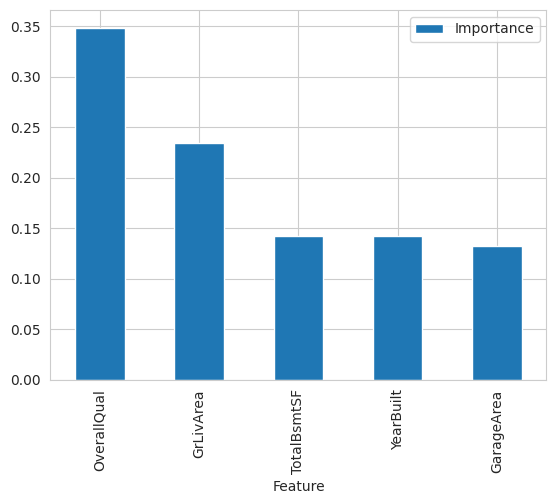

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [252]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.917
Mean Absolute Error: 14454.437
Mean Squared Error: 510444039.492
Root Mean Squared Error: 22593.009


* Test Set
R2 Score: 0.819
Mean Absolute Error: 20246.761
Mean Squared Error: 1246539227.305
Root Mean Squared Error: 35306.362




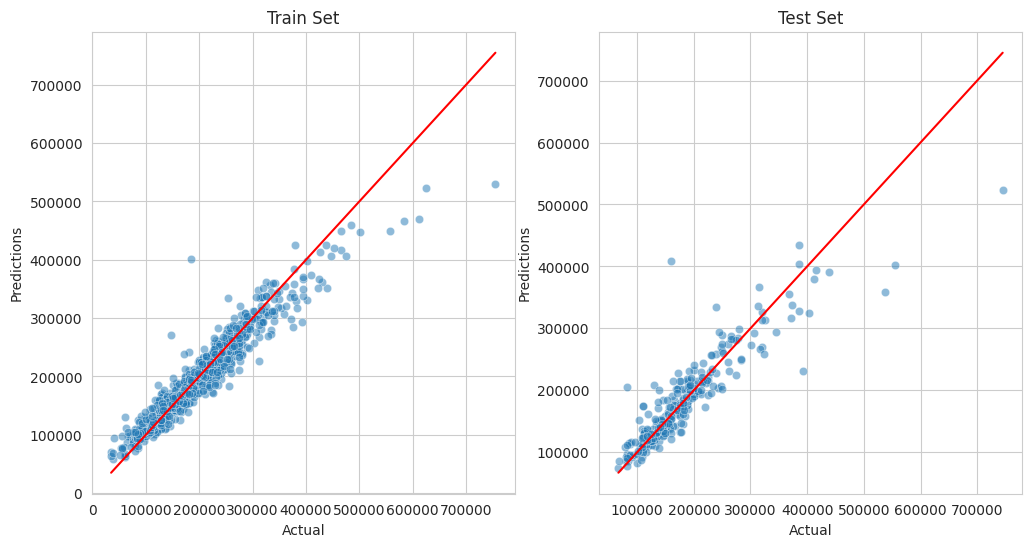

In [253]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

The model has achieved a strong predictive accuracy with an R² of 0.917 on the training set and 0.819 on the test set, indicating good but not perfect generalisation. The increase in error metrics from train to test (MAE: +5.8K, RMSE: +12.7K) suggests mild overfitting, likely due to high feature dimensionality or noise in the data.

Next Steps would include:
* Implement PCA to reduce collinearity, remove noise, and improve generalisation.
* Refine hyperparameters to limit overfitting.

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [232]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 17 components explain 100.0% of the data 



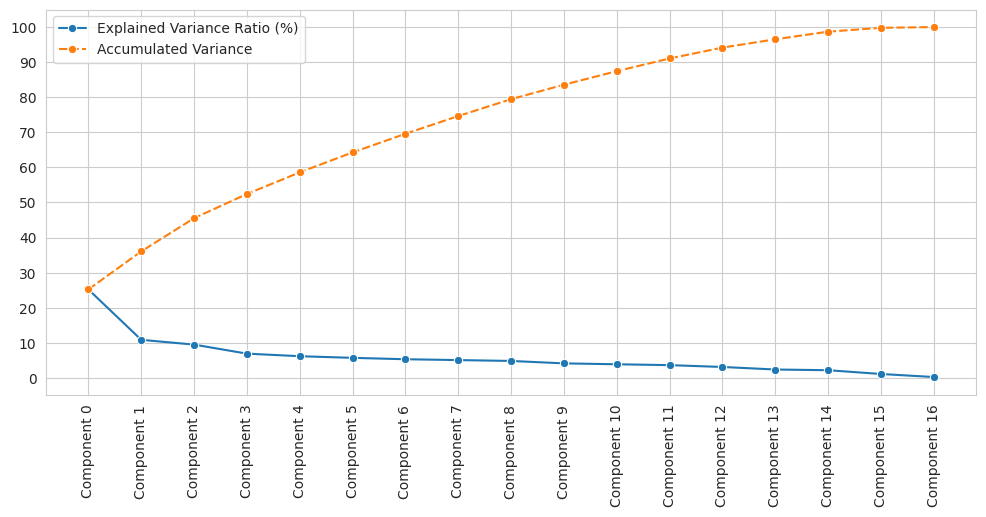

In [233]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 8 components explain 74.62% of the data 



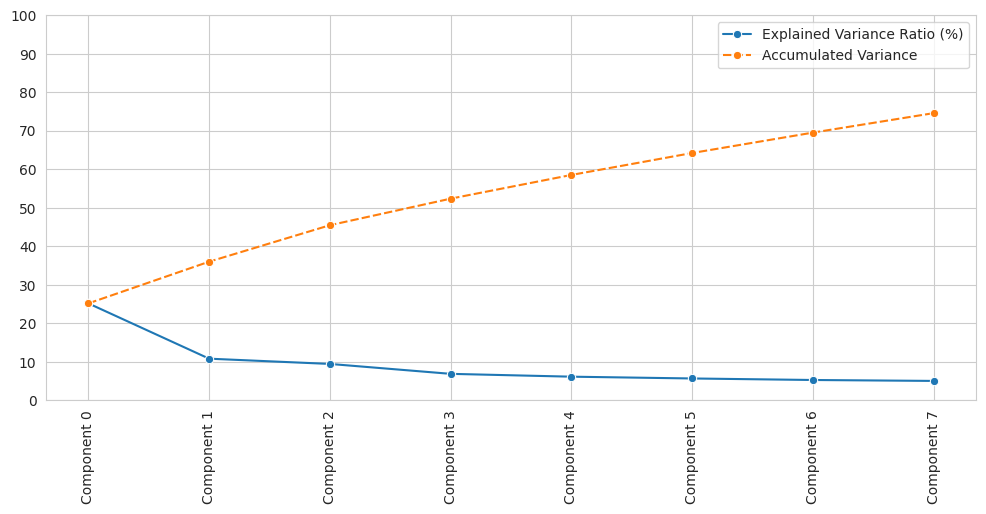

In [234]:
n_components = 8
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [235]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [236]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Use standard hyperparameters to find the most suitable model.

In [237]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [238]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.723499,0.76841,0.80392,0.0354
3,ExtraTreesRegressor,0.632353,0.756972,0.820373,0.071552
0,LinearRegression,0.665615,0.743441,0.781792,0.044411
5,GradientBoostingRegressor,0.625964,0.743202,0.806959,0.070841
6,XGBRegressor,0.632752,0.734817,0.787178,0.058974
4,AdaBoostRegressor,0.649668,0.717199,0.765622,0.040909
1,DecisionTreeRegressor,0.374887,0.578911,0.684701,0.107449


,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.723499,0.76841,0.80392,0.0354
3,ExtraTreesRegressor,0.632353,0.756972,0.820373,0.071552
0,LinearRegression,0.665615,0.743441,0.781792,0.044411
5,GradientBoostingRegressor,0.625964,0.743202,0.806959,0.070841
6,XGBRegressor,0.632752,0.734817,0.787178,0.058974
4,AdaBoostRegressor,0.649668,0.717199,0.765622,0.040909
1,DecisionTreeRegressor,0.374887,0.578911,0.684701,0.107449


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [ ]:
from sklearn.ensemble import RandomForestRegressor

models_search_pca = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [100, 300],
        'model__max_depth': [10, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt', 0.5]
    }
}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search_pca, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
29,RandomForestRegressor,0.742462,0.772639,0.807502,0.026101,None,0.5,2,2,300
11,RandomForestRegressor,0.743307,0.77217,0.811542,0.028707,10,0.5,1,5,300
9,RandomForestRegressor,0.744792,0.771587,0.812413,0.027873,10,0.5,1,2,300
10,RandomForestRegressor,0.737634,0.771566,0.812764,0.031081,10,0.5,1,5,100
25,RandomForestRegressor,0.746088,0.771512,0.809907,0.028612,None,0.5,1,2,300
15,RandomForestRegressor,0.740668,0.771355,0.808498,0.026366,10,0.5,2,5,300
27,RandomForestRegressor,0.741055,0.77124,0.810307,0.027433,None,0.5,1,5,300
28,RandomForestRegressor,0.734961,0.771114,0.805158,0.027703,None,0.5,2,2,100
26,RandomForestRegressor,0.737243,0.771034,0.806681,0.02855,None,0.5,1,5,100
8,RandomForestRegressor,0.740113,0.770995,0.814891,0.030659,10,0.5,1,2,100


Check the best model

In [ ]:
best_model_pca = grid_search_summary.iloc[0,0]
best_model_pca

'RandomForestRegressor'

Parameters for best model

In [ ]:
grid_search_pipelines[best_model_pca].best_params_


{'model__max_depth': None,
 'model__max_features': 0.5,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 300}

Define the best regressor

In [ ]:
best_regressor_pipeline_pca = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline_pca

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model',
                 RandomForestRegressor(max_features=0.5, min_samples_leaf=2,
                                       n_estimators=300, random_state=0))])

## Evaluate Regressor on Train and Tests Sets

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline_pca)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline_pca)

Model Evaluation 

* Train Set


ValueError: The number of columns in this dataset is different from the one used to fit this transformer (when using the fit() method).

# Which pipeline to choose?

We fitted 2 pipelines:
* Regression
* Regression with PCA

Didn't do classifier as we’d need to bucket SalePrice into categories (e.g., “Low”, “Medium”, “High”) and then train a classifier.
This means we’d lose the ability to predict exact prices, and the performance metrics would change (e.g., accuracy instead of RMSE).
Therefore it is not worth it to do one.

Additionally, we chose to continue with the Regression (ExtraTreesRegressor) as it lets you directly see which original features (ex: OverallQual, GrLivArea) drive the predictions, which is useful for explaining results to stakeholders or friends. PCA components are a mixture of variables, so while they can improve predictive performance, they don't directly tell us what aspects of a property are increasing or decreasing the price.
ExtraTreesRegressor can also capture complex, nonlinear interactions in the housing data, which PCA might not capture as well.

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [255]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_SalePrice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_SalePrice/v1'


## Train Set: features and target

In [256]:
X_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,1828,0.0,3.0,Av,48,Unf,1774,774,Unf,2007.0,...,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007
870,894,0.0,2.0,No,0,Unf,894,308,Unf,1962.0,...,TA,6600,60.0,0.0,0,5,5,894,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,...,TA,13360,80.0,0.0,0,7,5,876,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,...,Gd,13265,69.0,148.0,59,5,8,1568,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,...,Gd,13704,118.0,150.0,81,5,7,1541,2001,2002


In [259]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [260]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [261]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [262]:
X_test.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
529,2515,0.0,4.0,No,1219,Rec,816,484,Unf,1975.0,...,TA,32668,69.0,0.0,0,3,6,2035,1957,1975
491,958,620.0,3.0,No,403,BLQ,238,240,Unf,1941.0,...,Fa,9490,79.0,0.0,0,7,6,806,1941,1950
459,979,224.0,3.0,No,185,LwQ,524,352,Unf,1950.0,...,Gd,7015,69.0,161.0,0,4,5,709,1950,1950
279,1156,866.0,4.0,No,392,BLQ,768,505,Fin,1977.0,...,TA,10005,83.0,299.0,117,5,7,1160,1977,1977
655,525,0.0,3.0,No,0,Unf,525,264,Unf,1971.0,...,TA,1680,21.0,381.0,0,5,6,525,1971,1971


In [263]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [264]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [265]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting SalePrice

In [267]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2,
                                     min_samples_split=5, n_estimators=300,
                                     random_state=0))])

In [269]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_SalePrice/v1/best_regressor_pipeline.pkl']

## Feature importance plot

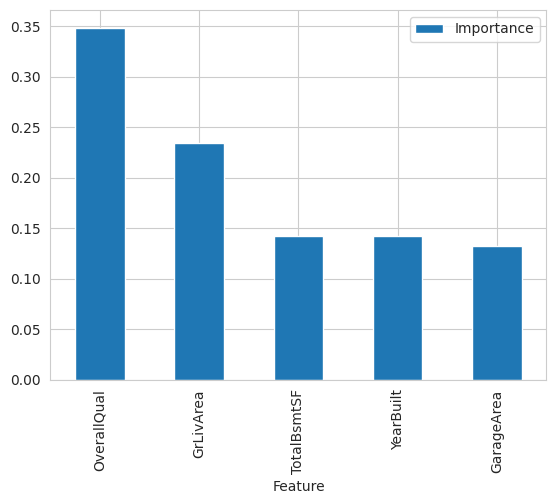

In [270]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

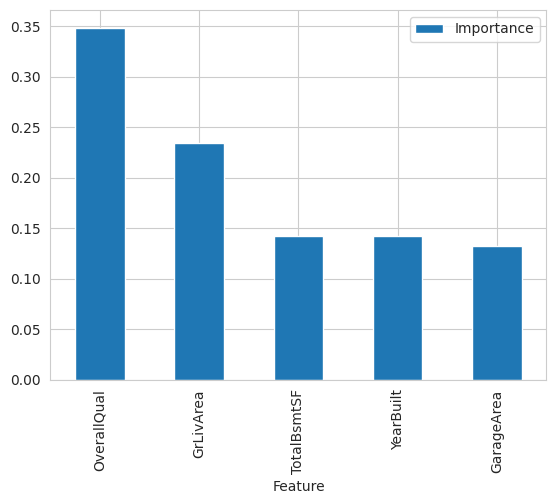

In [271]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

---